In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pickle
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks

class Autoencoder(object):
    
    def __init__(self):    
        
        # Encoding
        input_layer = Input(shape=(100, 100, 3)) 
        encoding_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
        encoding_pooling_layer_1 = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_1)
        encoding_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoding_pooling_layer_1)
        encoding_pooling_layer_2 = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_2)
        encoding_conv_layer_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoding_pooling_layer_2)
        code_layer = MaxPooling2D((2, 2), padding='same')(encoding_conv_layer_3)
        
        # Decoding
        decodging_conv_layer_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(code_layer)
        decodging_upsampling_layer_1 = UpSampling2D((2, 2))(decodging_conv_layer_1)
        decodging_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(decodging_upsampling_layer_1)
        decodging_upsampling_layer_2 = UpSampling2D((2, 2))(decodging_conv_layer_2)
        decodging_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')(decodging_upsampling_layer_2)
        decodging_upsampling_layer_3 = UpSampling2D((2, 2))(decodging_conv_layer_3)
        output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decodging_upsampling_layer_3)
        
        self._model = Model(input_layer, output_layer)
        self._model.compile(optimizer='adam', loss='mean_squared_error')
        
    def train(self, input_train, input_test, batch_size, epochs):    
        self._model.fit(input_train, 
                        input_train,
                        epochs = epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(
                                input_test, 
                                input_test))
        
    
    def getDecodedImage(self, encoded_imgs):
        decoded_image = self._model.predict(encoded_imgs)
        return decoded_image



Train on 6238 samples, validate on 6238 samples
Epoch 1/2
6238/6238 [==============================] - 40s 6ms/sample - loss: 0.0378 - val_loss: 0.0240
Epoch 2/2
6238/6238 [==============================] - 38s 6ms/sample - loss: 0.0211 - val_loss: 0.0191


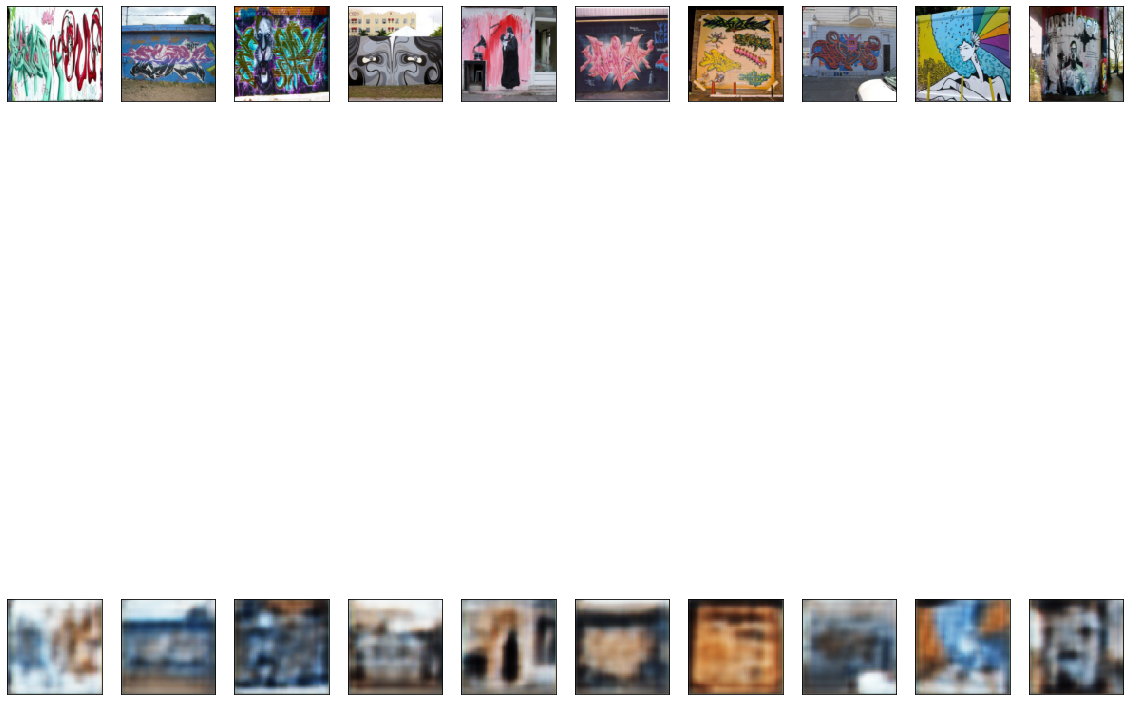

In [2]:
# Import data
with open('training_img.pkl', 'rb') as f:
    image_array = pickle.load(f)
train_data = np.array(image_array)

x_train, train_ground, x_test, test_ground = train_test_split(train_data,
                                                         train_data, 
                                                         test_size=0.2, 
                                                         random_state=42)
# Convolutional implementation
autoencoder = Autoencoder()

# tensorboard = callbacks.TensorBoard(
#     log_dir='logdir',
#     histogram_freq=0, 
#     write_graph=True,
#     update_freq='epoch')
#     # savename = "{0}_best.h5".format('6_class_model')
# savename = 'autoencoder_model.h5'

# mc = callbacks.ModelCheckpoint(
#     savename,
#     monitor='val_accuracy', 
#     verbose=0, 
#     save_best_only=True, 
#     mode='auto', 
#     save_freq='epoch')

autoencoder.train(x_train, x_test, 50, 2)
decoded_imgs = autoencoder.getDecodedImage(x_test)

# Convolutional implementation results
plt.figure(figsize=(20, 20))
for i in range(10):
    # Original
    subplot = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(100, 100,3))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)

    # Reconstruction
    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(100,100,3))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()

In [63]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import pickle
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras.models import load_model
import pandas as pd
import os,sys
# sys.path.append(os.path.abspath('..'))
from src.pickling_data_for_auto import format_image
from sklearn.metrics.pairwise import cosine_similarity
from src.finding_dominate_colors import resize
import matplotlib.pyplot as plt

def generate_encoded_dataframe(
                            pickled_file='data/training_img.pkl', 
                            saved_model='best_encoder_decoder.h5', 
                            file_paths='data/file_paths_full.csv', 
                            savename='encoded_dataframe.csv'):

    autoencoder = load_model(saved_model)

    # Import data
    with open(pickled_file, 'rb') as f:
        image_array = pickle.load(f)
    train_data = np.array(image_array)
    df = pd.read_csv(file_paths)

    #Accesses the encoder model inside the autoencoder model. Then runs a prediction
    predictions = autoencoder.get_layer('encoder').predict(train_data)
    
    final_df = pd.DataFrame(predictions) 
    final_df['file_path'] = df['file_path']

    final_df.to_csv(savename, header=True, index=None)
    return final_df

def process_new_image(img, saved_model='models/best_encoder_decoder.h5'):
    formatted = format_image(img)
    autoencoder = load_model(saved_model) 
    encoding = autoencoder.get_layer('encoder').predict(formatted.reshape(1, 100,100,3))
    return encoding

def make_recommendations(img_file_path, df_filepath='encoded_dataframe.csv'):
    df = pd.read_csv(df_filepath)
    files = df.pop('file_path')
    encoded_np = df.to_numpy()
    encoded_img = process_new_image(img_file_path)
    recommendations = cosine_similarity(encoded_img.reshape(1,-1), encoded_np)
    sorted_recommendations = np.argsort(recommendations)
    #Slice reverses the array to put the most similar at the start and then takes the top 5. Use [-2:-7:-1] if the image is in the training data
    top_5 = sorted_recommendations[0][:-6:-1] 
    #Retrieve the file path for 10 closest images
    file_paths = files.iloc[top_5]
    recommended_images = [resize(i) for i in file_paths]

    
    fig, axs = plt.subplots(1,5, figsize=(20,20))
    fig.suptitle("Recommended Images", fontsize=36, y=.63)
    plt.tight_layout()
    for i, ax in enumerate(axs.flat):
        ax.grid(False)
        ax.axis('off')
        ax.imshow(recommended_images[i])
    plt.show()


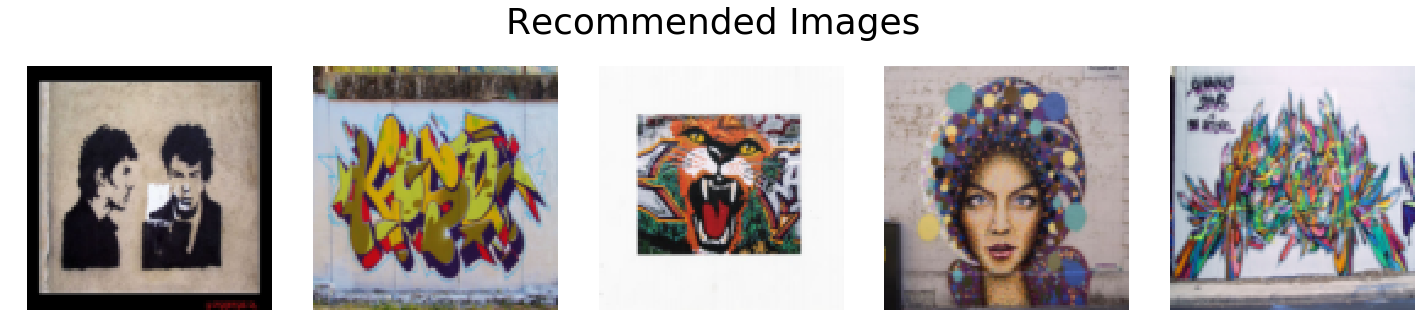

In [67]:
img_file_path = 'images/my_images/3d_space.JPG'
make_recommendations(img_file_path, df_filepath='encoded_dataframe.csv')